# Introduction

Set up the environmet for the analysis. Load the file to display results further down

In [617]:
input_path = "../automated_output/benchmark_OpenIE_Local_Cascade.json"

In [618]:
import json
import pandas as pd

with open(input_path) as f:
    data = json.load(f)

In [619]:
print("This benchmark is comprised of %i instances, with %i successes and a success rate of %f" % (data["size"], data["numSuccesses"], data["numSuccesses"]/data["size"]))

This benchmark is comprised of 43738 instances, with 12000 successes and a success rate of 0.274361


## Statistics for succesful cases

### Distribution of iterations per trail

In [620]:
stats = data["stats"]

iterationsDist = pd.Series(stats["iterationsDist"])

print(iterationsDist)

5        3
1    11097
2      821
3       74
4        5
dtype: int64


### Distribution of papers read per trail

In [621]:
papersDist = pd.Series(stats['papersDist'])
print(papersDist)

5     1155
10     126
24       2
25       1
14      25
20       5
1     1618
6      673
21       3
9      163
13      38
2     2574
17       4
27       1
12      47
7      421
3     2951
18      10
16      15
31       1
11      64
26       1
23       1
8      255
36       1
19       3
4     1823
15      19
dtype: int64


### Distribution of actions over all

In [622]:
actionDist = pd.Series(stats['actionDist'])
print(actionDist)

EXPLORATION           0
RANDOM                0
EXPLOITATION          0
EXPLORATION_DOUBLE    0
dtype: int64


A more detailed look at the cases with a path (_Successful_ cases). Preprocess the data and take a look into the structure of the data frame.

In [623]:
successes = [d for d in data['data'] if d['success']]

def num_documents(paths):
    '''
    This function computes the size of minimal set of documents for each path containes in the argument.
    Then it returns the smallest size.
    '''
    def helper(l, r, total):
        cum = l | r
        if len(l & r) > 0:
            return (cum, total)
        else:
            return (cum, total + 1)
        
    totals = list()
        
    for path in paths:
        doc_sets = [{a['document'] for a in edge['attributions']} for edge in path]
        if len(doc_sets) == 1:
            totals.append(1)
        else:
            sumation = 1
            current = doc_sets[0]
            for n in doc_sets[1:]:
                current, sumation = helper(current, n, sumation)
            totals.append(sumation)
    
    return min(totals)

for s in successes:
    s['min_papers'] = num_documents(s['paths'])


f = pd.DataFrame({k: d[k] for k in set(d.keys()).difference({'success', 'paths'})} for d in successes)
f.set_index('id', inplace=True)
print(f.head())
print("Num elements: %i" % f.shape[0])

            actions errors  iterations  min_papers  papersRead
id                                                            
WH_train_15      {}     []           1           1           2
WH_train_18      {}     []           1           1           2
WH_train_21      {}     []           1           2           3
WH_train_28      {}     []           1           2           4
WH_train_29      {}     []           1           2           3
Num elements: 12000


In [624]:
# Small sanity check. No epoch should've read less than the paper lower bound computer for it.
print(all(f.min_papers <= f.papersRead))

True


Take a look at the paper distributions

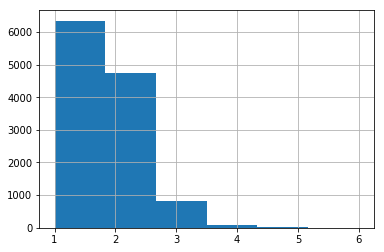

In [625]:
import matplotlib.pyplot as plt
f.min_papers.hist(bins=f.min_papers.max())
plt.show()

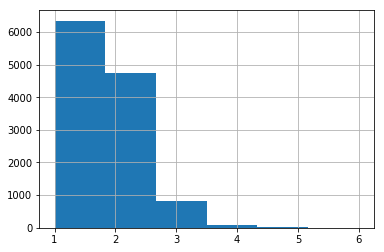

In [626]:
import matplotlib.pyplot as plt
f.min_papers.hist(bins=f.min_papers.max())
plt.show()

In [627]:
f.min_papers.mean()

1.55775

In [628]:
f.min_papers.std()

0.6652331536855307

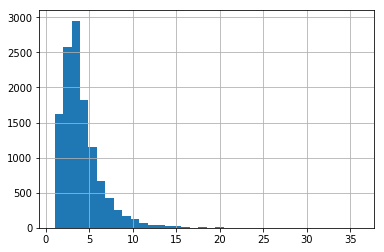

In [629]:
f.papersRead.hist(bins=f.papersRead.max())
plt.show()

In [630]:
f.papersRead.mean()


3.6465833333333335

In [631]:
f.papersRead.std()

2.460525250516901

Out of the instances finished after one iteration. What is the paper distribution?

In [632]:
# lucky_ones = f[f.actions.map(lambda r: sum(r.values())) == 1]
# lucky_ones.papersRead.hist(bins=lucky_ones.papersRead.max())
# plt.show()

# Error analysis

In [633]:
# First, isolate the negative cases

failures = [d for d in data['data'] if not d['success']]


s = pd.DataFrame({k: d[k] for k in set(d.keys()).difference({'success', 'paths'})} for d in failures)
s.set_index('id', inplace=True)
print(s.head())
print("Num elements: %i" % s.shape[0])

           actions errors  iterations  papersRead
id                                               
WH_train_0      {}     []          10           1
WH_train_1      {}     []          10           1
WH_train_2      {}     []          10           2
WH_train_3      {}     []          10           2
WH_train_4      {}     []          10          17
Num elements: 31715


How many of the failures were due to _iteration exhaustion_?

In [634]:
max_iter = s.iterations.max()

exhausted = s[s.iterations == max_iter]

percent = exhausted.shape[0]/s.shape[0]

print("%i out of %i, or %f" % (exhausted.shape[0], s.shape[0], percent))

31621 out of 31715, or 0.997036


The reminder of failures, had the following distribution of iterations:

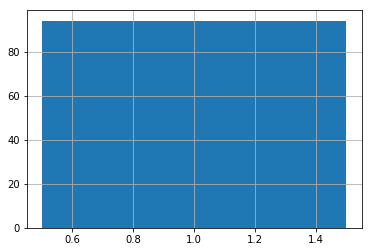

In [635]:
not_exhausted = s[s.iterations != max_iter]
not_exhausted.iterations.hist(bins=not_exhausted.iterations.max())
plt.show()

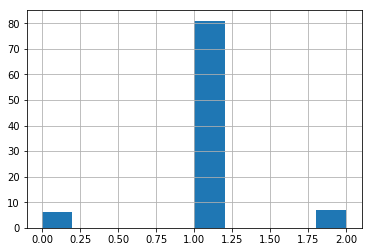

In [636]:
not_exhausted.papersRead.hist()
plt.show()

The explanation for this is that the information retrieval returned a small amount of papers, and no new data was added to the knowledge graph or any other reason that lead to _action starvation_